In [1]:
import sys
import inspect
from importlib import reload
from tqdm import tqdm

import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.constants import pi, c, epsilon_0, mu_0

rcParams['figure.figsize'] = (8,6)
rcParams['font.size'] = 20

import quvac
from quvac.paraxial_gaussian import ParaxialGaussianAnalytic
from quvac.field import ExternalField
from quvac.vacuum_emission import VacuumEmission
from quvac.analytic_scalings import get_two_paraxial_scaling

### Utility functions for grid determination

In [2]:
def kmax_grid(laser_params):
    '''
    Laser params must include lam, tau, w0, theta and phi
    theta, phi in degrees
    '''
    lam, tau = laser_params['lam'], laser_params['tau']
    theta, phi = laser_params['theta'], laser_params['phi']
    if 'w0' in laser_params.keys():
        w0 = laser_params['w0']
    elif 'w0x' in laser_params.keys():
        w0 = min(laser_params['w0x'], laser_params['w0y'])
    
    k = 2*np.pi/lam    
    theta /= 180/np.pi
    phi /= 180/np.pi
    
    ekx = np.sin(theta) * np.cos(phi)
    eky = np.sin(theta) * np.sin(phi)
    ekz = np.cos(theta)
    ek = np.array([ekx, eky, ekz])

    if np.sin(theta) == 0.0:
        phi = 0.0
    
    e1x = -np.sin(phi)
    e1y = np.cos(phi)
    e1z = 0.0
    e1 = np.array([e1x, e1y, e1z])

    e2x = np.cos(phi) * np.cos(theta)
    e2y = np.sin(phi) * np.cos(theta)
    e2z = -np.sin(theta)
    e2 = np.array([e2x, e2y, e2z])
        
    kbw_perp = 4/w0
    kbw_long = 8/(c*tau)
    
    k0 = ek * k
    kmax = np.abs(k0 + ek * kbw_long)
    
    for beta in np.linspace(0, 2*np.pi, 64, endpoint=False):
        kp = k0 + ek * kbw_long + kbw_perp * (np.sin(beta) * e1 + np.cos(beta) * e2)
        kmax = np.maximum(kmax, np.abs(kp))
    
    return kmax


def get_spatial_steps(lasers, L, grid_res=1, equal_resolution=False):
    '''
    Calculates necessary spatial resolution
    
    grid_res: [float] - controls the resolution
    '''
    kmax = np.zeros((3,))
    for laser_params in lasers:
        kmax = np.maximum(kmax, kmax_grid(laser_params))
    
    # test cigar conjecture
    if equal_resolution:
        kmax = np.max(kmax) * np.ones(3) 
    N = np.ceil(grid_res * L * 3 * kmax/np.pi).astype(int)
    # N = [pp.helper.fftw_padsize(n) for n in N]
    return N


def get_t_steps(t_start, t_end, lam, grid_res=1):
    '''
    Calculates necessary temporal resolution
    
    grid_res: [float] - controls the resolution
    '''
    fmax = c/lam
    return int(np.ceil((t_end-t_start)*fmax*6*grid_res))

## Test: two paraxial gaussians for different collision angles

In [30]:
tau = 20e-15
W = 25
lam = 0.8e-6
w0 = 1*lam
thetas = np.linspace(0,180,19)

field_1 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 180,
    "phi": 0,
    "beta": 90,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1, field_2]

x0, y0, z0 = 10*w0, 4*w0, 10*w0
L = np.array([x0, y0, z0])
Nxyz = get_spatial_steps(fields_params, L)
print(Nxyz)
Nx, Ny, Nz = Nxyz
x = np.linspace(-x0,x0,2*Nx).reshape((-1,1,1))
y = np.linspace(-y0,y0,2*Ny).reshape((1,-1,1))
z = np.linspace(-z0,z0,2*Nz).reshape((1,1,-1))
grid = (x, y, z)

t0 = 2*tau
Nt = get_t_steps(-t0, t0, lam)
print(Nt)
t_grid = np.linspace(-t0, t0, Nt)

[39 16 71]
180


In [32]:
Ntots = np.zeros_like(thetas)
Nths = np.zeros_like(thetas)

In [33]:
for i,theta in enumerate(tqdm(thetas)):
    field_2['theta'] = float(theta)
    fields_params = [field_1, field_2]

    Nxyz = get_spatial_steps(fields_params, L)
    Nx, Ny, Nz = Nxyz
    x = np.linspace(-x0,x0,2*Nx).reshape((-1,1,1))
    y = np.linspace(-y0,y0,2*Ny).reshape((1,-1,1))
    z = np.linspace(-z0,z0,2*Nz).reshape((1,1,-1))
    grid = (x, y, z)
    
    field = ExternalField(fields_params, grid)
    vacem = VacuumEmission(field)
    vacem.calculate_vacuum_current(t_grid)
    Ntot = vacem.calculate_total_signal()
    Ntots[i] = Ntot

    N_signal, N_perp = get_two_paraxial_scaling(fields_params)
    Nths[i] = N_signal

  0%|                                                    | 0/19 [00:00<?, ?it/s]/home/maximus/Research/github/quantum-vacuum/src/quvac/analytic_scalings.py:54: RuntimeWarning: invalid value encountered in scalar divide
  theta_term = (1 - np.cos(theta_c))**4 / np.sqrt(cos_term + sin_term)
/home/maximus/Research/github/quantum-vacuum/src/quvac/analytic_scalings.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  theta_term *= 1/np.sqrt((T1/tau1*w01/w1)**2*cos_term + sin_term)
100%|███████████████████████████████████████████| 19/19 [13:28<00:00, 42.56s/it]


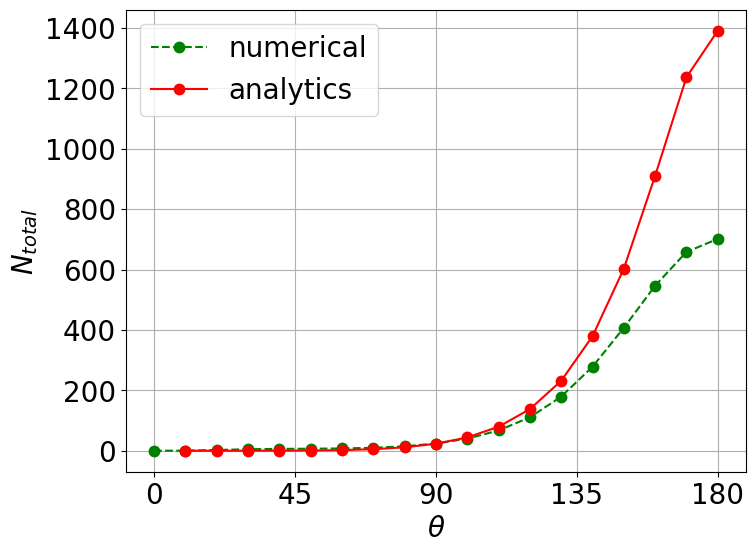

In [41]:
# This is for comparison with Fig.6 from H. Gies, et al "All-optical signatures of 
# strong-field QED in the vacuum emission picture." Physical Review D 97.3 (2018): 036022.

plt.figure(figsize=(8,6))
# plt.subplot(1,2,1)
plt.plot(thetas, Ntots, '.--', color='green', ms=15, label='numerical')
plt.plot(thetas[1:], Nths[1:], '.-', color='red', ms=15, label='analytics')
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('$N_{total}$')
plt.xticks([45*i for i in range(5)])
plt.legend(loc='best')
# plt.yticks([50*i for i in range(7)])

# plt.subplot(1,2,2)
# plt.plot(thetas[1:], np.abs(Ntots-Nths)[1:]/Nths[1:]*100, '.--', color='tab:blue', ms=15, label='relative error')
# # plt.plot(thetas, Nths, '.-', color='red', ms=15, label='analytics')
# plt.grid()
# plt.xlabel('$\\theta$')
# plt.ylabel('Error [%]')
# plt.xticks([45*i for i in range(5)])
# # plt.legend(loc='best')

plt.savefig('../imgs/tests/2_paraxial_Ntot_theta_beta_90.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
plt.plot(thetas, np.abs(Ntots-Nths)/Nths*100, '.--', color='green', ms=15, label='relative error')
# plt.plot(thetas, Nths, '.-', color='red', ms=15, label='analytics')
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('Error [%]')
plt.xticks([45*i for i in range(5)])
plt.legend(loc='best')
plt.savefig('../imgs/tests/2_paraxial_Ntot_theta_beta_90_error.png')
plt.show()

In [27]:
N_signal, N_perp = get_two_paraxial_scaling(fields_params)
print(N_signal)
print(N_perp)

922.3583607640411
63.85557882212592


In [28]:
field = ExternalField(fields_params, grid)
vacem = VacuumEmission(field)
vacem.calculate_vacuum_current(t_grid)
Ntot = vacem.calculate_total_signal()
print(Ntot)

438.3223525392014


In [11]:
Ntot*2

np.float64(870.3000753625385)

In [12]:
N_signal / Ntot

np.float64(2.119632956207241)

In [31]:
Ntots = np.zeros_like(thetas)

In [32]:
for i,theta in enumerate(tqdm(thetas)):
    field_2['theta'] = float(theta)
    fields_params = [field_1, field_2]
    
    field = ExternalField(fields_params, grid)
    vacem = VacuumEmission(field)
    vacem.calculate_vacuum_current(t_grid)
    Ntot = vacem.calculate_total_signal()
    Ntots[i] = Ntot

100%|███████████████████████████████████████████| 19/19 [01:58<00:00,  6.25s/it]


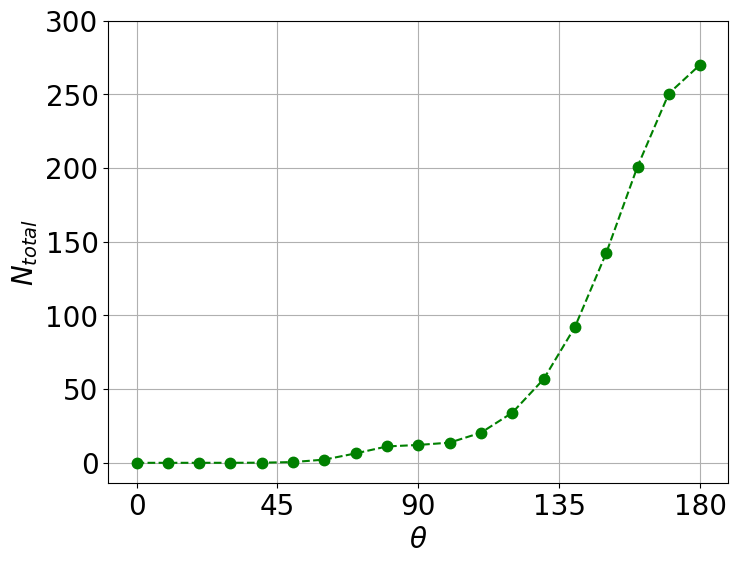

In [33]:
# This is for comparison with Fig.6 from H. Gies, et al "All-optical signatures of 
# strong-field QED in the vacuum emission picture." Physical Review D 97.3 (2018): 036022.

plt.figure()
plt.plot(thetas, Ntots, '.--', color='green', ms=15)
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('$N_{total}$')
plt.xticks([45*i for i in range(5)])
plt.yticks([50*i for i in range(7)])
plt.savefig('../imgs/tests/2_paraxial_Ntot_theta.png')
plt.show()

In [42]:
# formula (57) from F. Karbstein. "Probing vacuum polarization effects with
# high-intensity lasers." Particles 3.1 (2020): 39-61.
Nth = 2*1.46e-2 * W**3 * (1e-6/lam)**5
print(f"Theory estimate: {Nth:.2f}")
print(f"Numerical value: {Ntot:.2f}")

Theory estimate: 1392.36
Numerical value: 607.84


### Test Euler rotation

In [27]:
from scipy.spatial.transform import Rotation
phi = 67*np.pi/180
theta = 145*np.pi/180
beta = 45*np.pi/180
k = np.array([np.cos(phi)*np.sin(theta),
              np.sin(phi)*np.sin(theta),
              np.cos(theta)])
print(f'k      : {k}')
e1 = np.array([np.cos(phi)*np.cos(theta),
               np.sin(phi)*np.cos(theta),
               -np.sin(theta)])
e2 = np.array([-np.sin(phi),
               np.cos(phi),
               0.])
eb = e1 * np.cos(beta) + e2 * np.sin(beta)

rotation = Rotation.from_euler('ZYZ', (phi,theta,beta))
rotation_bwd = rotation.inv()

k_rotated = rotation_bwd.apply(k)
print(f'k(rot) : {k_rotated}')

eb_rotated = rotation_bwd.apply(eb)
print(f'eb     : {eb}')
print(f'eb(rot): {eb_rotated}')

eb_ = rotation.apply(eb_rotated)
print(f'eb...  : {eb_}')

k      : [ 0.22411417  0.52797989 -0.81915204]
k(rot) : [-2.77555756e-17 -5.55111512e-17  1.00000000e+00]
eb     : [-0.87721762 -0.25689352 -0.40557979]
eb(rot): [ 1.00000000e+00 -8.32667268e-17  0.00000000e+00]
eb...  : [-0.87721762 -0.25689352 -0.40557979]
